In [12]:
# 데이터 수집 및 저장

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Spark 세션 생성
spark = SparkSession.builder.appName("StackOverflowSurvey").getOrCreate()

# CSV 파일 읽기
data1 = spark.read.csv("./stack-overflow-developer-survey-2023/survey_results_public.csv", header=True, inferSchema=True)
data2 = spark.read.csv("./stack-overflow-developer-survey-2022/survey_results_public.csv", header=True, inferSchema=True)
data3 = spark.read.csv("./stack-overflow-developer-survey-2021/survey_results_public.csv", header=True, inferSchema=True)
data4 = spark.read.csv("./stack-overflow-developer-survey-2020/survey_results_public.csv", header=True, inferSchema=True)
data5 = spark.read.csv("./stack-overflow-developer-survey-2019/survey_results_public.csv", header=True, inferSchema=True)

# 포함할 학위 리스트 매핑
degree_mapping = {
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
    "Other doctoral degree (Ph.D, Ed.D., etc.)": "Ph.D"
}

# 학위 매핑을 적용하는 함수
def map_degrees(df):
    for k, v in degree_mapping.items():
        df = df.withColumn("EdLevel", when(col("EdLevel") == k, v).otherwise(col("EdLevel")))
    return df

# 데이터프레임에 학위 매핑 적용
data1 = map_degrees(data1)
data2 = map_degrees(data2)
data3 = map_degrees(data3)
data4 = map_degrees(data4)
data5 = map_degrees(data5)

# 학위가 포함된 데이터 필터링
def filter_degrees(df):
    degrees = list(degree_mapping.values())
    return df.filter(col("EdLevel").isin(*degrees))

filtered_df1 = filter_degrees(data1)
filtered_df2 = filter_degrees(data2)
filtered_df3 = filter_degrees(data3)
filtered_df4 = filter_degrees(data4)
filtered_df5 = filter_degrees(data5)

# 필요한 컬럼만 선택
columns = ["EdLevel", "DevType", "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith", "ConvertedCompYearly", "YearsCode"]
filtered_df1 = filtered_df1.select(*columns)
filtered_df2 = filtered_df2.select(*columns)
filtered_df3 = filtered_df3.select(*columns)

# 2020, 2019 데이터는 컬럼 이름이 다름
columns_rename = {
    "LanguageWorkedWith": "LanguageHaveWorkedWith",
    "DatabaseWorkedWith": "DatabaseHaveWorkedWith",
    "PlatformWorkedWith": "PlatformHaveWorkedWith",
    "ConvertedComp": "ConvertedCompYearly"
}

for old_col, new_col in columns_rename.items():
    filtered_df4 = filtered_df4.withColumnRenamed(old_col, new_col)
    filtered_df5 = filtered_df5.withColumnRenamed(old_col, new_col)

filtered_df4 = filtered_df4.select(*columns)
filtered_df5 = filtered_df5.select(*columns)

# NA 값 제거
filtered_df1 = filtered_df1.na.drop()
filtered_df2 = filtered_df2.na.drop()
filtered_df3 = filtered_df3.na.drop()
filtered_df4 = filtered_df4.na.drop()
filtered_df5 = filtered_df5.na.drop()

# 데이터프레임 병합
filtered_df = filtered_df1.union(filtered_df2).union(filtered_df3).union(filtered_df4).union(filtered_df5)

# PySpark 데이터프레임을 Pandas 데이터프레임으로 변환
pandas_df = filtered_df.toPandas()

# 결과 CSV 파일로 저장
pandas_df.to_csv("filtered.csv", index=False)

24/06/15 19:41:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


24/06/15 19:41:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------------+------------------+
|EdLevel         |AverageSalary     |
+----------------+------------------+
|Ph.D            |171504.37904649795|
|Bachelor        |128540.09119488978|
|Master          |117125.6303232486 |
|Secondary school|92032.42066276803 |
+----------------+------------------+



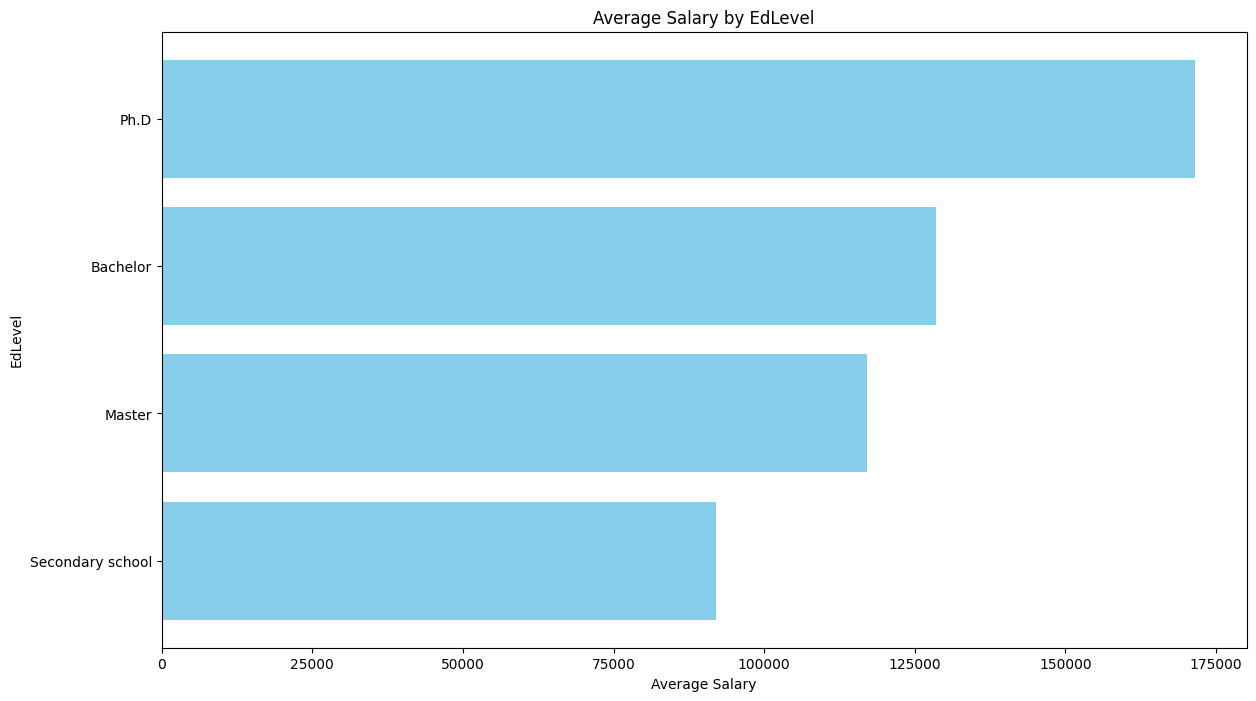

In [13]:
# 학력별 연봉 분석

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, split, explode
import matplotlib.pyplot as plt

# SparkSession 생성
spark = SparkSession.builder \
    .appName("CSV Example") \
    .getOrCreate()

csv_file_path = "filtered.csv"

# CSV 파일 불러오기
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# EdLevel별 평균 연봉 계산
average_salary_df = df.groupBy("EdLevel").agg(avg("ConvertedCompYearly").alias("AverageSalary"))
average_salary_df = average_salary_df.orderBy(average_salary_df["AverageSalary"].desc())

# 결과 출력
average_salary_df.show(average_salary_df.count(), truncate=False)
pandas_df = average_salary_df.toPandas()
pandas_df = pandas_df.sort_values(by="AverageSalary", ascending=False)
plt.figure(figsize=(14, 8))
plt.barh(pandas_df['EdLevel'], pandas_df['AverageSalary'], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('EdLevel')
plt.title('Average Salary by EdLevel')
plt.gca().invert_yaxis()
plt.show()

pandas_df.to_csv("school_income.csv")

+---------------------------------------------+------------------+
|DevType                                      |AverageSalary     |
+---------------------------------------------+------------------+
|Blockchain                                   |295640.11527377524|
|Senior Executive (C-Suite, VP, etc.)         |248164.30391734827|
|Cloud infrastructure engineer                |235896.2114837976 |
|Project manager                              |196836.57538625467|
|Marketing or sales professional              |190040.85714285713|
|Engineering manager                          |187028.4049070848 |
|Security professional                        |185074.29154228856|
|Engineer, site reliability                   |178825.7807761501 |
|Other (please specify):                      |157009.07679324894|
|Senior executive/VP                          |155583.06666666668|
|DevOps specialist                            |145096.3351950785 |
|Engineer, data                               |144311.68851369

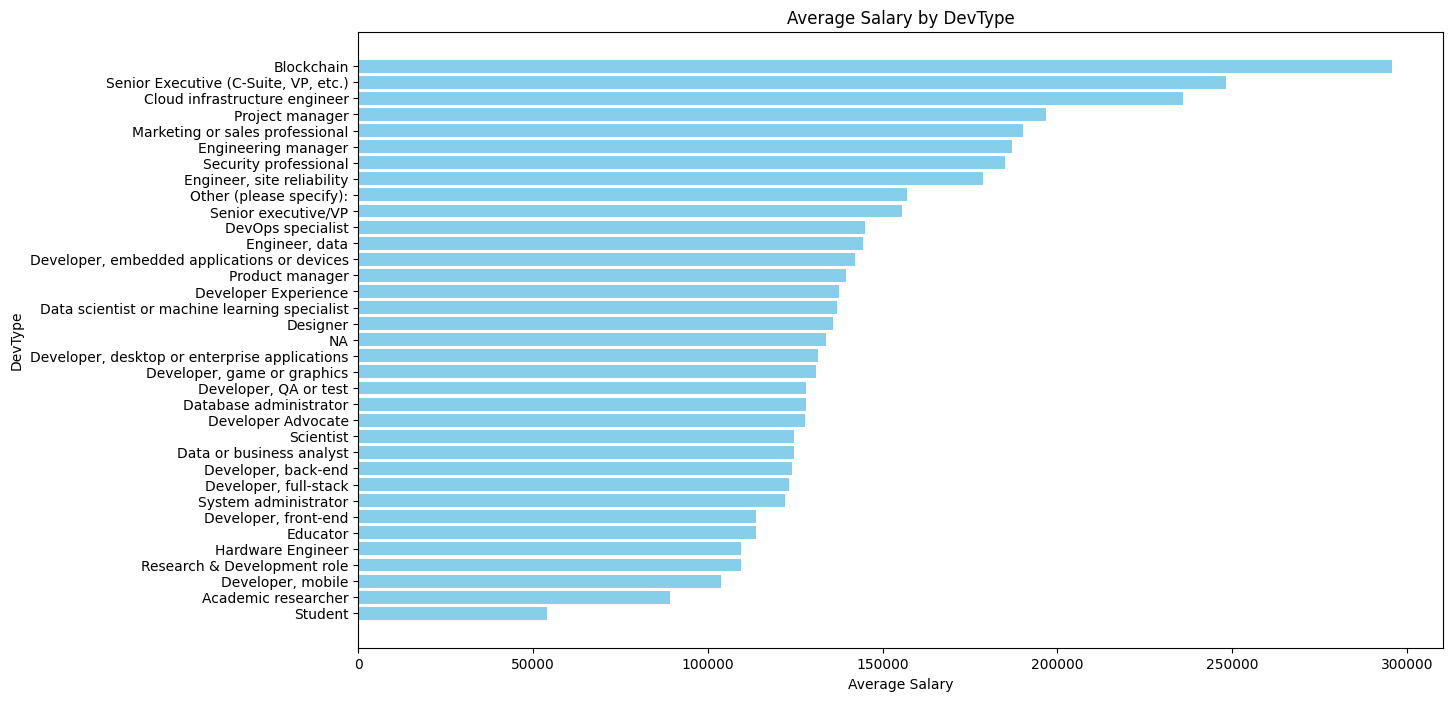

In [14]:
# DevType별 연봉 분석

# DevType 컬럼을 분리하여 배열로 변환
df = df.withColumn("DevType", split(df["DevType"], ";"))

# 배열을 행으로 확장
df = df.withColumn("DevType", explode(df["DevType"]))

# 결과 확인
# DevType별 평균 연봉 계산
average_salary_df = df.groupBy("DevType").agg(avg("ConvertedCompYearly").alias("AverageSalary"))
average_salary_df = average_salary_df.orderBy(average_salary_df["AverageSalary"].desc())

# 결과 출력
average_salary_df.show(average_salary_df.count(), truncate=False)
pandas_df = average_salary_df.toPandas()
pandas_df = pandas_df.sort_values(by="AverageSalary", ascending=False)
plt.figure(figsize=(14, 8))
plt.barh(pandas_df['DevType'], pandas_df['AverageSalary'], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('DevType')
plt.title('Average Salary by DevType')
plt.gca().invert_yaxis()
plt.show()

+-----------------------+------------------+
|LanguageHaveWorkedWith |AverageSalary     |
+-----------------------+------------------+
|OCaml                  |2062046.5885608855|
|SAS                    |1964836.0119581465|
|APL                    |1640398.422446406 |
|Fortran                |1414992.1986899562|
|COBOL                  |1078669.8446937015|
|Crystal                |1048599.4288135592|
|LISP                   |798291.7047244095 |
|Solidity               |771445.1869103773 |
|Erlang                 |648434.8603896104 |
|Julia                  |621649.7657916325 |
|Cobol                  |581695.7076023392 |
|F#                     |578569.4349173554 |
|Ada                    |549359.7908163265 |
|Prolog                 |468374.921875     |
|Lua                    |408070.26189397374|
|MATLAB                 |406900.88582111016|
|Haskell                |361119.7567103285 |
|Groovy                 |323653.91421998246|
|Delphi                 |317000.0688155922 |
|Lisp     

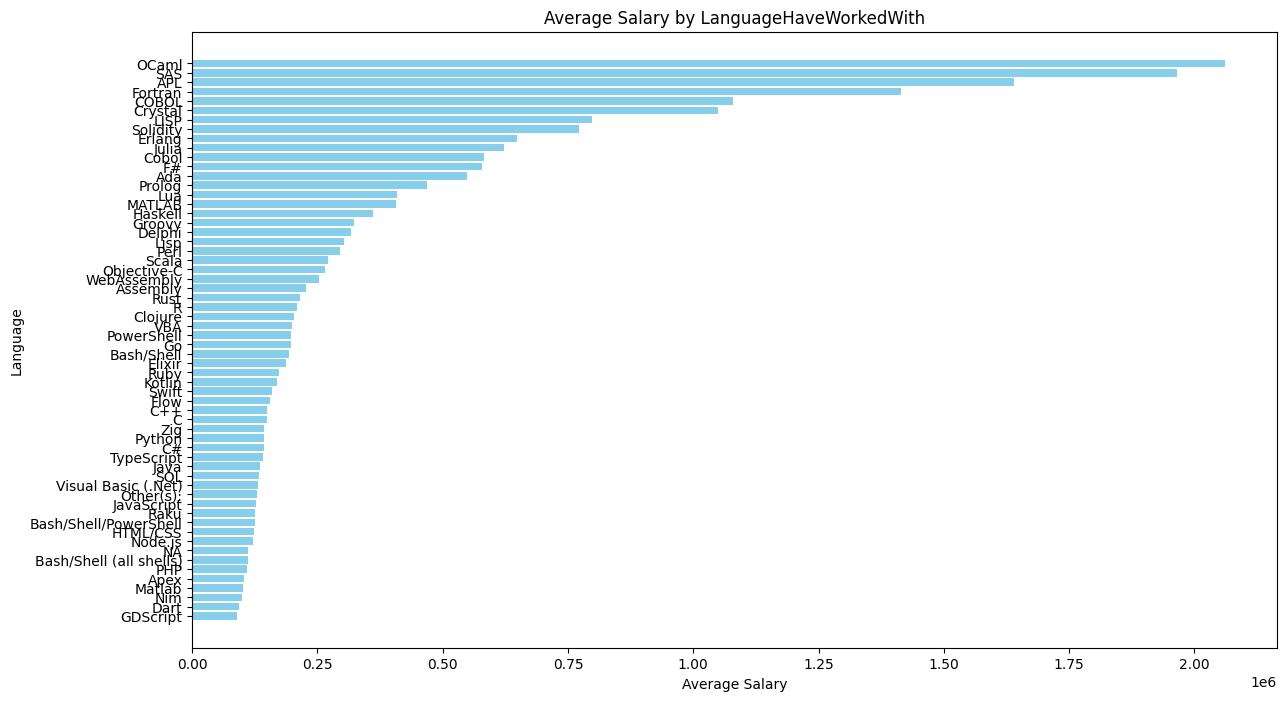

In [15]:
#사용 언어별 연봉분석

df = df.withColumn("LanguageHaveWorkedWith", split(df["LanguageHaveWorkedWith"], ";"))

# 배열을 행으로 확장
df = df.withColumn("LanguageHaveWorkedWith", explode(df["LanguageHaveWorkedWith"]))

# 결과 확인

average_salary_df = df.groupBy("LanguageHaveWorkedWith").agg(avg("ConvertedCompYearly").alias("AverageSalary"))
average_salary_df = average_salary_df.orderBy(average_salary_df["AverageSalary"].desc())

# 결과 출력
average_salary_df.show(average_salary_df.count(), truncate=False)
pandas_df = average_salary_df.toPandas()
pandas_df = pandas_df.sort_values(by="AverageSalary", ascending=False)
plt.figure(figsize=(14, 8))
plt.barh(pandas_df['LanguageHaveWorkedWith'], pandas_df['AverageSalary'], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('Language')
plt.title('Average Salary by LanguageHaveWorkedWith')
plt.gca().invert_yaxis()
plt.show()

pandas_df.to_csv("language_income.csv")

+--------------------------+------------------+
|DatabaseHaveWorkedWith    |AverageSalary     |
+--------------------------+------------------+
|CouchDB                   |3214521.958117647 |
|Neo4j                     |2853751.1948278267|
|Couchbase                 |1135585.4797602273|
|Cloud Firestore           |930865.9278367583 |
|IBM DB2                   |900279.8887828592 |
|Firebase Realtime Database|882038.3374580411 |
|Cassandra                 |765568.0888155061 |
|Firebird                  |642855.7924970692 |
|DynamoDB                  |444668.7010430137 |
|Oracle                    |280648.4171630135 |
|Microsoft Access          |252982.28435420967|
|Redis                     |239420.12661749247|
|MariaDB                   |220237.06430107862|
|Microsoft SQL Server      |208310.9538392064 |
|MongoDB                   |198438.69158937872|
|SQLite                    |194048.08525323504|
|PostgreSQL                |190049.78586270273|
|MySQL                     |166676.30138

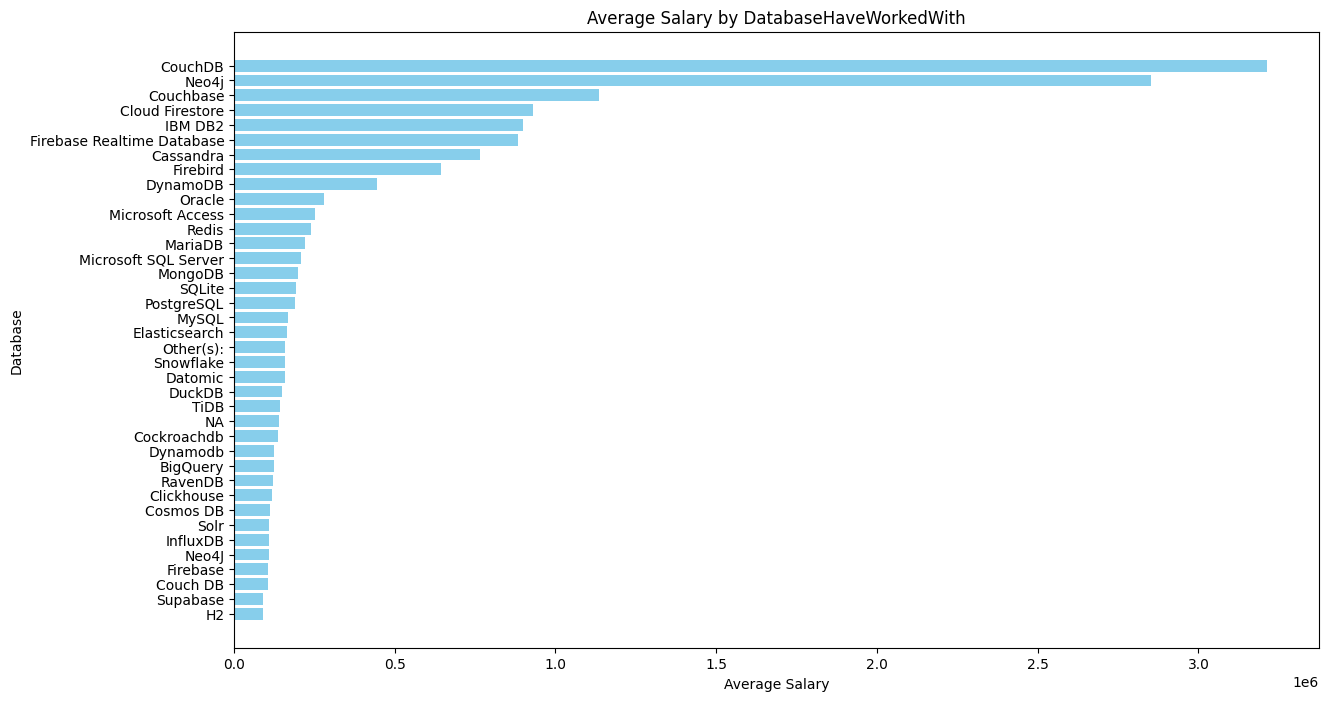

In [16]:
#사용 데이터베이스별 연봉분석

df = df.withColumn("DatabaseHaveWorkedWith", split(df["DatabaseHaveWorkedWith"], ";"))

# 배열을 행으로 확장
df = df.withColumn("DatabaseHaveWorkedWith", explode(df["DatabaseHaveWorkedWith"]))

# 결과 확인
average_salary_df = df.groupBy("DatabaseHaveWorkedWith").agg(avg("ConvertedCompYearly").alias("AverageSalary"))
average_salary_df = average_salary_df.orderBy(average_salary_df["AverageSalary"].desc())

# 결과 출력
average_salary_df.show(average_salary_df.count(), truncate=False)
pandas_df = average_salary_df.toPandas()
pandas_df = pandas_df.sort_values(by="AverageSalary", ascending=False)
plt.figure(figsize=(14, 8))
plt.barh(pandas_df['DatabaseHaveWorkedWith'], pandas_df['AverageSalary'], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('Database')
plt.title('Average Salary by DatabaseHaveWorkedWith')
plt.gca().invert_yaxis()
plt.show()

pandas_df.to_csv("database_income.csv")

+---------------------------------+------------------+
|PlatformHaveWorkedWith           |AverageSalary     |
+---------------------------------+------------------+
|Colocation                       |7520544.504924212 |
|Linode                           |5694376.852408829 |
|OpenStack                        |5254773.011152715 |
|Oracle Cloud Infrastructure      |4997688.258147207 |
|OVH                              |3845723.044021076 |
|Managed Hosting                  |3171581.9825925147|
|IBM Cloud or Watson              |2684438.087866272 |
|VMware                           |2239413.9126111697|
|Firebase                         |1308125.9077562804|
|Google Cloud                     |1027314.0533742113|
|Heroku                           |663855.9388078285 |
|Microsoft Azure                  |497950.7271877859 |
|AWS                              |401017.9230180403 |
|Other(s):                        |238792.07381146704|
|Slack                            |235565.83420661857|
|Cloudflar

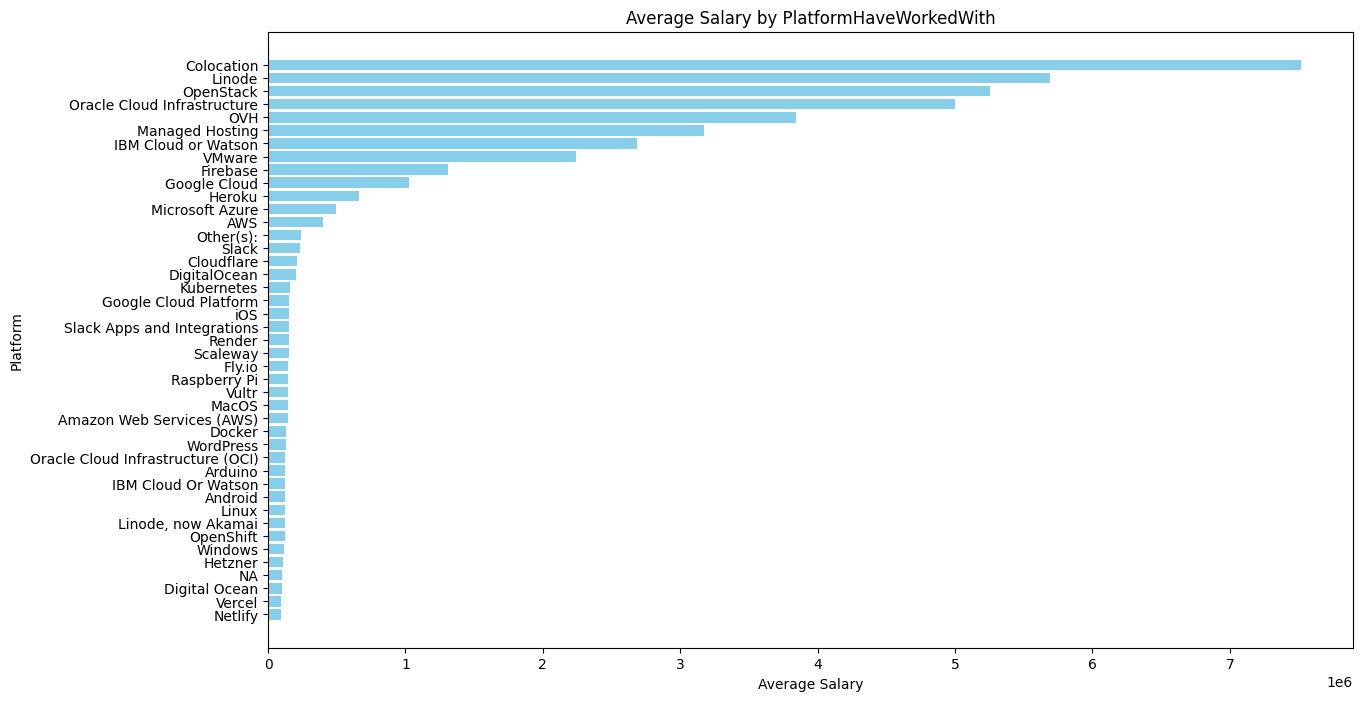

In [17]:
#사용 플렛폼별 연봉분석

df = df.withColumn("PlatformHaveWorkedWith", split(df["PlatformHaveWorkedWith"], ";"))

# 배열을 행으로 확장
df = df.withColumn("PlatformHaveWorkedWith", explode(df["PlatformHaveWorkedWith"]))

# 결과 확인
average_salary_df = df.groupBy("PlatformHaveWorkedWith").agg(avg("ConvertedCompYearly").alias("AverageSalary"))
average_salary_df = average_salary_df.orderBy(average_salary_df["AverageSalary"].desc())

# 결과 출력
average_salary_df.show(average_salary_df.count(), truncate=False)
pandas_df = average_salary_df.toPandas()
pandas_df = pandas_df.sort_values(by="AverageSalary", ascending=False)
plt.figure(figsize=(14, 8))
plt.barh(pandas_df['PlatformHaveWorkedWith'], pandas_df['AverageSalary'], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('Platform')
plt.title('Average Salary by PlatformHaveWorkedWith')
plt.gca().invert_yaxis()
plt.show()

pandas_df.to_csv("platform_income.csv")

In [18]:
# DevType별 사용 언어, 데이터베이스, 플렛폼 사용 순위 분석

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, count
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("DevType Rankings") \
    .getOrCreate()

# CSV 파일 로드
df = spark.read.option("header", "true").csv("filtered.csv")

# DevType 필드 분리 및 변환
df = df.select(
    col("EdLevel"),
    explode(split(col("DevType"), ";")).alias("DevType"),
    col("LanguageHaveWorkedWith"),
    col("DatabaseHaveWorkedWith"),
    col("PlatformHaveWorkedWith"),
    col("ConvertedCompYearly")
)

# Language 필드 분리 및 변환
df_languages = df.select(
    col("DevType"),
    explode(split(col("LanguageHaveWorkedWith"), ";")).alias("Language")
)

# Database 필드 분리 및 변환
df_databases = df.select(
    col("DevType"),
    explode(split(col("DatabaseHaveWorkedWith"), ";")).alias("Database")
)

# Platform 필드 분리 및 변환
df_platforms = df.select(
    col("DevType"),
    explode(split(col("PlatformHaveWorkedWith"), ";")).alias("Platform")
)

# Language 순위 계산
language_window = Window.partitionBy("DevType").orderBy(col("Count").desc())
language_rankings = df_languages.groupBy("DevType", "Language") \
    .agg(count("Language").alias("Count")) \
    .withColumn("Rank", row_number().over(language_window)) \
    .orderBy("DevType", "Rank")

# Database 순위 계산
database_window = Window.partitionBy("DevType").orderBy(col("Count").desc())
database_rankings = df_databases.groupBy("DevType", "Database") \
    .agg(count("Database").alias("Count")) \
    .withColumn("Rank", row_number().over(database_window)) \
    .orderBy("DevType", "Rank")

# Platform 순위 계산
platform_window = Window.partitionBy("DevType").orderBy(col("Count").desc())
platform_rankings = df_platforms.groupBy("DevType", "Platform") \
    .agg(count("Platform").alias("Count")) \
    .withColumn("Rank", row_number().over(platform_window)) \
    .orderBy("DevType", "Rank")

pd_language_rankings = language_rankings.toPandas()
pd_database_rankings = database_rankings.toPandas()
pd_platform_rankings = platform_rankings.toPandas()

# Pandas DataFrame을 CSV 파일로 저장
pd_language_rankings.to_csv("devtype_language.csv", index=False)
pd_database_rankings.to_csv("devtype_database.csv", index=False)
pd_platform_rankings.to_csv("devtype_platform.csv", index=False)


24/06/15 19:42:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [19]:
# DevType 경력별 사용 언어, 데이터베이스, 플렛폼 사용 순위 분석

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, count, when
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("DevType Rankings by YearsCode") \
    .getOrCreate()

# CSV 파일 로드
df = spark.read.option("header", "true").csv("filtered.csv")

# YearsCode를 기반으로 그룹 분류
df = df.withColumn("YearsGroup", 
                   when(col("YearsCode").cast("int").between(0, 3), "junior")
                   .when(col("YearsCode").cast("int").between(4, 6), "middle")
                   .otherwise("senior"))

# DevType 필드 분리 및 변환
df = df.select(
    col("YearsGroup"),
    col("EdLevel"),
    explode(split(col("DevType"), ";")).alias("DevType"),
    col("LanguageHaveWorkedWith"),
    col("DatabaseHaveWorkedWith"),
    col("PlatformHaveWorkedWith"),
    col("ConvertedCompYearly")
)

# 필드 분리 및 변환
df_languages = df.select(
    col("YearsGroup"),
    col("DevType"),
    explode(split(col("LanguageHaveWorkedWith"), ";")).alias("Language")
)

df_databases = df.select(
    col("YearsGroup"),
    col("DevType"),
    explode(split(col("DatabaseHaveWorkedWith"), ";")).alias("Database")
)

df_platforms = df.select(
    col("YearsGroup"),
    col("DevType"),
    explode(split(col("PlatformHaveWorkedWith"), ";")).alias("Platform")
)

# 순위 계산 함수 정의
def calculate_rankings(df, column, filename_prefix):
    window = Window.partitionBy("YearsGroup", "DevType").orderBy(col("Count").desc())
    rankings = df.groupBy("YearsGroup", "DevType", column) \
        .agg(count(column).alias("Count")) \
        .withColumn("Rank", row_number().over(window)) \
        .orderBy("YearsGroup", "DevType", "Rank")
    
    # 그룹별 CSV 파일 저장
    for group in ["junior", "middle", "senior"]:
        group_rankings = rankings.filter(col("YearsGroup") == group)
        group_rankings.toPandas().to_csv(f"{group}_{filename_prefix}.csv", index=False)

# Language 순위 계산 및 저장
calculate_rankings(df_languages, "Language", "devtype_language")

# Database 순위 계산 및 저장
calculate_rankings(df_databases, "Database", "devtype_database")

# Platform 순위 계산 및 저장
calculate_rankings(df_platforms, "Platform", "devtype_platform")


24/06/15 19:42:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [20]:
# Web, Tool 정보 담아서 다시 저장

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Spark 세션 생성
spark = SparkSession.builder.appName("StackOverflowSurvey").getOrCreate()

# CSV 파일 읽기
data1 = spark.read.csv("./stack-overflow-developer-survey-2023/survey_results_public.csv", header=True, inferSchema=True)
data2 = spark.read.csv("./stack-overflow-developer-survey-2022/survey_results_public.csv", header=True, inferSchema=True)
data3 = spark.read.csv("./stack-overflow-developer-survey-2021/survey_results_public.csv", header=True, inferSchema=True)
data4 = spark.read.csv("./stack-overflow-developer-survey-2020/survey_results_public.csv", header=True, inferSchema=True)

# 포함할 학위 리스트 매핑
degree_mapping = {
    "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor",
    "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master",
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
    "Other doctoral degree (Ph.D, Ed.D., etc.)": "Ph.D"
}

# 학위 매핑을 적용하는 함수
def map_degrees(df):
    for k, v in degree_mapping.items():
        df = df.withColumn("EdLevel", when(col("EdLevel") == k, v).otherwise(col("EdLevel")))
    return df

# 데이터프레임에 학위 매핑 적용
data1 = map_degrees(data1)
data2 = map_degrees(data2)
data3 = map_degrees(data3)
data4 = map_degrees(data4)

# 학위가 포함된 데이터 필터링
def filter_degrees(df):
    degrees = list(degree_mapping.values())
    return df.filter(col("EdLevel").isin(*degrees))

filtered_df1 = filter_degrees(data1)
filtered_df2 = filter_degrees(data2)
filtered_df3 = filter_degrees(data3)
filtered_df4 = filter_degrees(data4)

# 필요한 컬럼만 선택
columns = ["EdLevel", "DevType", "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith", "ConvertedCompYearly", "YearsCode", "WebframeHaveWorkedWith", "NEWCollabToolsHaveWorkedWith"]
filtered_df1 = filtered_df1.select(*columns)
filtered_df2 = filtered_df2.select(*columns)
filtered_df3 = filtered_df3.select(*columns)

# 2020 데이터는 컬럼 이름이 다름
columns_rename = {
    "LanguageWorkedWith": "LanguageHaveWorkedWith",
    "DatabaseWorkedWith": "DatabaseHaveWorkedWith",
    "PlatformWorkedWith": "PlatformHaveWorkedWith",
    "ConvertedComp": "ConvertedCompYearly",
    "WebframeWorkedWith": "WebframeHaveWorkedWith",
    "NEWCollabToolsWorkedWith": "NEWCollabToolsHaveWorkedWith"
}

for old_col, new_col in columns_rename.items():
    filtered_df4 = filtered_df4.withColumnRenamed(old_col, new_col)

filtered_df4 = filtered_df4.select(*columns)

# NA 값 제거
filtered_df1 = filtered_df1.na.drop()
filtered_df2 = filtered_df2.na.drop()
filtered_df3 = filtered_df3.na.drop()
filtered_df4 = filtered_df4.na.drop()

# 데이터프레임 병합
filtered_df = filtered_df1.union(filtered_df2).union(filtered_df3).union(filtered_df4)

# PySpark DataFrame을 Pandas DataFrame으로 변환
pandas_df = filtered_df.toPandas()

# 결과 CSV 파일로 저장
pandas_df.to_csv("filtered2.csv", index=False)

24/06/15 19:42:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [21]:
# DevType 경력별 웹,툴 사용 순위 분석

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, count, when
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("DevType Rankings by YearsGroup") \
    .getOrCreate()

# CSV 파일 로드
df = spark.read.option("header", "true").csv("filtered2.csv")
# YearsCode를 기반으로 그룹 분류
df = df.withColumn("YearsGroup", 
                   when(col("YearsCode").cast("int").between(0, 3), "junior")
                   .when(col("YearsCode").cast("int").between(4, 6), "middle")
                   .otherwise("senior"))

# DevType 필드 분리 및 변환
df = df.select(
    col("YearsGroup"),
    col("EdLevel"),
    explode(split(col("DevType"), ";")).alias("DevType"),
    col("LanguageHaveWorkedWith"),
    col("DatabaseHaveWorkedWith"),
    col("PlatformHaveWorkedWith"),
    col("ConvertedCompYearly"),
    col("WebframeHaveWorkedWith"),
    col("NEWCollabToolsHaveWorkedWith")
)

# 필드 분리 및 변환
df_web = df.select(
    col("YearsGroup"),
    col("DevType"),
    explode(split(col("WebframeHaveWorkedWith"), ";")).alias("Webframe")
)

df_tools = df.select(
    col("YearsGroup"),
    col("DevType"),
    explode(split(col("NEWCollabToolsHaveWorkedWith"), ";")).alias("Tools")
)

# 순위 계산 함수 정의
def calculate_rankings(df, column, filename_prefix):
    window = Window.partitionBy("YearsGroup", "DevType").orderBy(col("Count").desc())
    rankings = df.groupBy("YearsGroup", "DevType", column) \
        .agg(count(column).alias("Count")) \
        .withColumn("Rank", row_number().over(window)) \
        .orderBy("YearsGroup", "DevType", "Rank")
    
    # 그룹별 CSV 파일 저장
    for group in ["junior", "middle", "senior"]:
        group_rankings = rankings.filter(col("YearsGroup") == group)
        group_rankings.toPandas().to_csv(f"{group}_{filename_prefix}.csv", index=False)

# Webframe 순위 계산 및 저장
calculate_rankings(df_web, "Webframe", "devtype_framework")

# Tools 순위 계산 및 저장
calculate_rankings(df_tools, "Tools", "devtype_tools")

24/06/15 19:42:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [22]:
# DevType 경력별 연봉 분석

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("DevType Salary Rankings by YearsGroup") \
    .getOrCreate()

# CSV 파일 로드
df = spark.read.option("header", "true").csv("filtered2.csv")

# YearsCode를 기반으로 그룹 분류
df = df.withColumn("YearsGroup", 
                   when(col("YearsCode").cast("int").between(0, 3), "junior")
                   .when(col("YearsCode").cast("int").between(4, 6), "middle")
                   .otherwise("senior"))

# DevType 필드 분리 및 변환
df = df.select(
    col("YearsGroup"),
    col("EdLevel"),
    explode(split(col("DevType"), ";")).alias("DevType"),
    col("LanguageHaveWorkedWith"),
    col("DatabaseHaveWorkedWith"),
    col("PlatformHaveWorkedWith"),
    col("ConvertedCompYearly").cast("float"),
    col("WebframeHaveWorkedWith"),
    col("NEWCollabToolsHaveWorkedWith")
)

# 순위 계산 함수 정의
def calculate_salary_rankings(df, filename_prefix):
    # DevType별 평균 연봉 계산 및 내림차순 정렬
    rankings = df.groupBy("YearsGroup", "DevType") \
        .agg(mean("ConvertedCompYearly").alias("AverageSalary")) \
        .orderBy("YearsGroup", col("AverageSalary").desc())
    
    # 그룹별 CSV 파일 저장
    for group in ["junior", "middle", "senior"]:
        group_rankings = rankings.filter(col("YearsGroup") == group)
        group_rankings.toPandas().to_csv(f"{group}_{filename_prefix}.csv", index=False)

# Salary 순위 계산 및 저장
calculate_salary_rankings(df, "devtype_salary")

24/06/15 19:42:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
